In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"
data = pd.read_csv(url)

In [21]:
data.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [22]:
data.columns

Index(['engine_displacement', 'num_cylinders', 'horsepower', 'vehicle_weight',
       'acceleration', 'model_year', 'origin', 'fuel_type', 'drivetrain',
       'num_doors', 'fuel_efficiency_mpg'],
      dtype='object')

In [26]:
cols = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
df = data[cols]

In [ ]:
print(df.head())
print(df.shape)

(9704, 5)

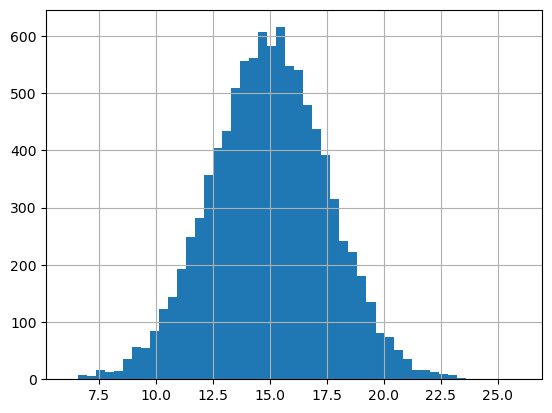

In [36]:
df['fuel_efficiency_mpg'].hist(bins = 50)
plt.show()

fuel_efficiency_mpg column does not have a long tail. In fact, it is fairly symmetrical and normally distributed.

Q1: Missing Values

In [38]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

horsepower column has missing values out of the remaining in the given question.

Q2: Median of horsepower

In [37]:
df['horsepower'].median()

149.0

Preparing the dataset

In [42]:
n = len(df)

In [43]:
idx = np.arange(n)

In [44]:
# shuffling the dataset
np.random.seed(42)
np.random.shuffle(idx)

In [48]:
df_shuffled = df.iloc[idx]
df_shuffled.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
483,220,144.0,2535.887591,2009,16.642943
7506,160,141.0,2741.170484,2019,16.298377
8795,230,155.0,2471.880237,2017,18.591822
1688,150,206.0,3748.164469,2015,11.818843
6217,300,111.0,2135.716359,2006,19.402209


In [49]:
n_val = int(n * 0.2)
n_test = int(n * 0.2)

n_train = n - n_val - n_test

In [ ]:
df_train = df_shuffled.iloc[idx[:n_train]]
df_val = df_shuffled.iloc[idx[n_train: n_train+n_val]]
df_test = df_shuffled.iloc[idx[n_train + n_val:]]

Code for Linear Regression

In [56]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [75]:
def rmse(y, ypred):
    se = (y - ypred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

Fill with 0:

In [103]:
base = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
X_train_0 = df_train[base].fillna(0).values
X_val_0 = df_val[base].fillna(0).values
X_test_0 = df_test[base].fillna(0).values

y_train = df_train['fuel_efficiency_mpg']
y_val = df_val['fuel_efficiency_mpg']
y_test = df_test['fuel_efficiency_mpg']

In [ ]:
w0, w = train_linear_regression(X_train_0, y_train)
y_pred = w0 + X_val_0.dot(w)

In [110]:
val_score_fill_0 = rmse(y_val, y_pred)
print(np.round(score_fill_0, 8))

0.5151415


Filling with the mean in the training set

In [112]:
mean_horsepower = df_train['horsepower'].mean()
print(mean_horsepower)

149.87847866419295


In [125]:
X_train = df_train[base].fillna(mean_horsepower)
X_val = df_val[base].fillna(mean_horsepower)

In [126]:
w0, w = train_linear_regression(X_train, y_train)
y_pred = w0 + X_val.dot(w)

In [127]:
score = rmse(y_val, y_pred)
print(np.round(score,2))

0.47


Filling missing values with the mean results in a lower RMSE.

Q4: Best regularization

In [128]:
r = [0, 0.01, 0.1, 1, 5, 10, 100]

In [129]:
X_train = df_train[base].fillna(0).values
X_val = df_val[base].fillna(0).values
X_test = df_test[base].fillna(0).values

In [138]:
def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [140]:
for reg in r:
    w0, w = train_linear_regression_reg(X_train, y_train, reg)
    y_pred = w0 + X_val.dot(w)

    score = np.round(rmse(y_val, y_pred),2)

    print(reg, score, sep = '  ')

0  0.52
0.01  0.52
0.1  0.53
1  0.53
5  0.53
10  0.53
100  0.53


r = 0 gives the lowest rmse

Q5

In [174]:
sum = []
for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(s)
    
    idx = np.arange(n)
    np.random.shuffle(idx)

    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test
 
    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[idx[:n_train]]
    df_val = df_shuffled.iloc[idx[n_train: n_train+n_val]]
    df_test = df_shuffled.iloc[idx[n_train + n_val:]]

    X_train = df_train[base].fillna(0).values
    X_val = df_val[base].fillna(0).values
    # X_test = df_test[base].fillna(0).values

    y_train = df_train['fuel_efficiency_mpg'].values
    y_val = df_val['fuel_efficiency_mpg'].values


    w0, w = train_linear_regression(X_train, y_train)
    y_pred = w0 + X_val.dot(w)

    score = np.round(rmse(y_val, y_pred),4)

    sum.append(score)


    print(s, score, sep = '   ')
print(np.round(np.std(sum), 3))

0   0.5077
1   0.5122
2   0.5169
3   0.5069
4   0.5214
5   0.5129
6   0.5128
7   0.5093
8   0.5191
9   0.5088
0.005


Q6

In [167]:
np.random.seed(9)

In [178]:
idx = np.arange(n)
np.random.shuffle(idx)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[idx[:n_train]]
df_val = df_shuffled.iloc[idx[n_train: n_train+n_val]]
df_test = df_shuffled.iloc[idx[n_train + n_val:]]

df_full_train = pd.concat([df_train, df_val])

X_train = df_full_train[base].fillna(0).values
X_test = df_test[base].fillna(0).values

y_train = df_full_train['fuel_efficiency_mpg'].values
y_test = df_test['fuel_efficiency_mpg'].values

w0, w = train_linear_regression_reg(X_train, y_train, r=0.001)
y_pred = w0 + X_test.dot(w)

score = np.round(rmse(y_test, y_pred),3)

print(score)

0.519
